In [1]:
%matplotlib inline
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

In [2]:
data = pd.read_csv('./data/low_temp_overall.csv')
data.head()

,"gas_feed temperature, C","gas_feed pressure, kPa","gas_feed mass flow, kg/h",gas_feed molecular weight,"gas_feed Mass density, kg/m3","gas_feed actual liquid flow, m3/h","gas_feed actual vapour flow, m3/h",gas_feed mass heat capacity,gas_feed Methane mass frac,gas_feed Ethane mass frac,...,"17 actual liquid flow, m3/h","17 actual vapour flow, m3/h",17 mass heat capacity,17 Methane mass frac,17 Ethane mass frac,17 Propane mass frac,17 i-Butane mass frac,17 n-Butane mass frac,17 i-Pentane mass frac,17 n-Pentane mass frac
0,-23.0,4041.0,21277.0,23.956971,73.393036,18.015246,271.889646,2.552841,0.508804,0.071252,...,16.473024,0.671735,2.248443,0.055855,0.065350,0.159964,0.362796,0.318673,0.009351,0.028012
1,-11.0,4320.0,6634.0,28.122865,103.408737,7.785243,56.367944,2.562291,0.358629,0.128836,...,7.471808,0.002190,3.172211,0.000006,0.092802,0.051350,0.424403,0.380461,0.026824,0.024153
2,9.0,4299.0,22552.0,27.218717,79.662664,20.458362,262.635360,2.574080,0.375699,0.151103,...,18.949131,0.423676,2.593380,0.022762,0.091335,0.049298,0.296327,0.511004,0.008935,0.020340
3,-15.0,4214.0,9679.0,23.387540,70.663424,6.863007,130.110260,2.640162,0.498093,0.158571,...,6.564201,0.000000,3.120212,0.000004,0.117264,0.232341,0.524567,0.045849,0.047009,0.032967
4,-15.0,3757.0,7193.0,19.586848,42.874012,1.841248,165.929382,2.504826,0.740581,0.022713,...,2.215091,0.131402,2.214229,0.048311,0.015410,0.058774,0.532420,0.216966,0.099379,0.028739


## Определение объемных расходов пара и жидкости сырьевого потока

In [20]:
feed_prod_vol_flow = data[[
    'gas_feed temperature, C', 'gas_feed pressure, kPa', 'gas_feed mass flow, kg/h', 'gas_feed actual liquid flow, m3/h',
    'gas_feed actual vapour flow, m3/h', 'gas_feed Methane mass frac', 'gas_feed Ethane mass frac',
    'gas_feed Propane mass frac', 'gas_feed i-Butane mass frac', 'gas_feed n-Butane mass frac',
    'gas_feed i-Pentane mass frac','gas_feed n-Pentane mass frac',
]]

In [22]:
feed_prod_vol_flow.describe()

,"gas_feed temperature, C","gas_feed pressure, kPa","gas_feed mass flow, kg/h","gas_feed actual liquid flow, m3/h","gas_feed actual vapour flow, m3/h",gas_feed Methane mass frac,gas_feed Ethane mass frac,gas_feed Propane mass frac,gas_feed i-Butane mass frac,gas_feed n-Butane mass frac,gas_feed i-Pentane mass frac,gas_feed n-Pentane mass frac
count,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000
mean,-8.480579,4207.666418,17513.410166,13.334570,236.913322,0.477853,0.123608,0.071424,0.143099,0.163792,0.010122,0.010102
std,10.266356,403.397921,7206.613928,7.586198,119.499390,0.080848,0.050958,0.030397,0.064333,0.086969,0.004279,0.004274
min,-25.000000,3500.000000,5000.000000,0.000000,21.448718,0.267349,0.010872,0.014322,0.021081,0.002458,0.002234,0.002290
25%,-17.000000,3860.000000,11290.000000,7.247971,141.562427,0.419732,0.086266,0.046392,0.089873,0.091571,0.006606,0.006578
50%,-9.000000,4211.000000,17518.000000,12.151037,220.801211,0.472422,0.126887,0.070418,0.143815,0.168010,0.009864,0.009854
75%,0.000000,4557.000000,23750.000000,18.383058,313.726759,0.530387,0.160727,0.093634,0.192630,0.235017,0.013161,0.013138
max,10.000000,4900.000000,30000.000000,46.708568,862.437275,0.853544,0.322328,0.221481,0.379844,0.428366,0.032362,0.030832


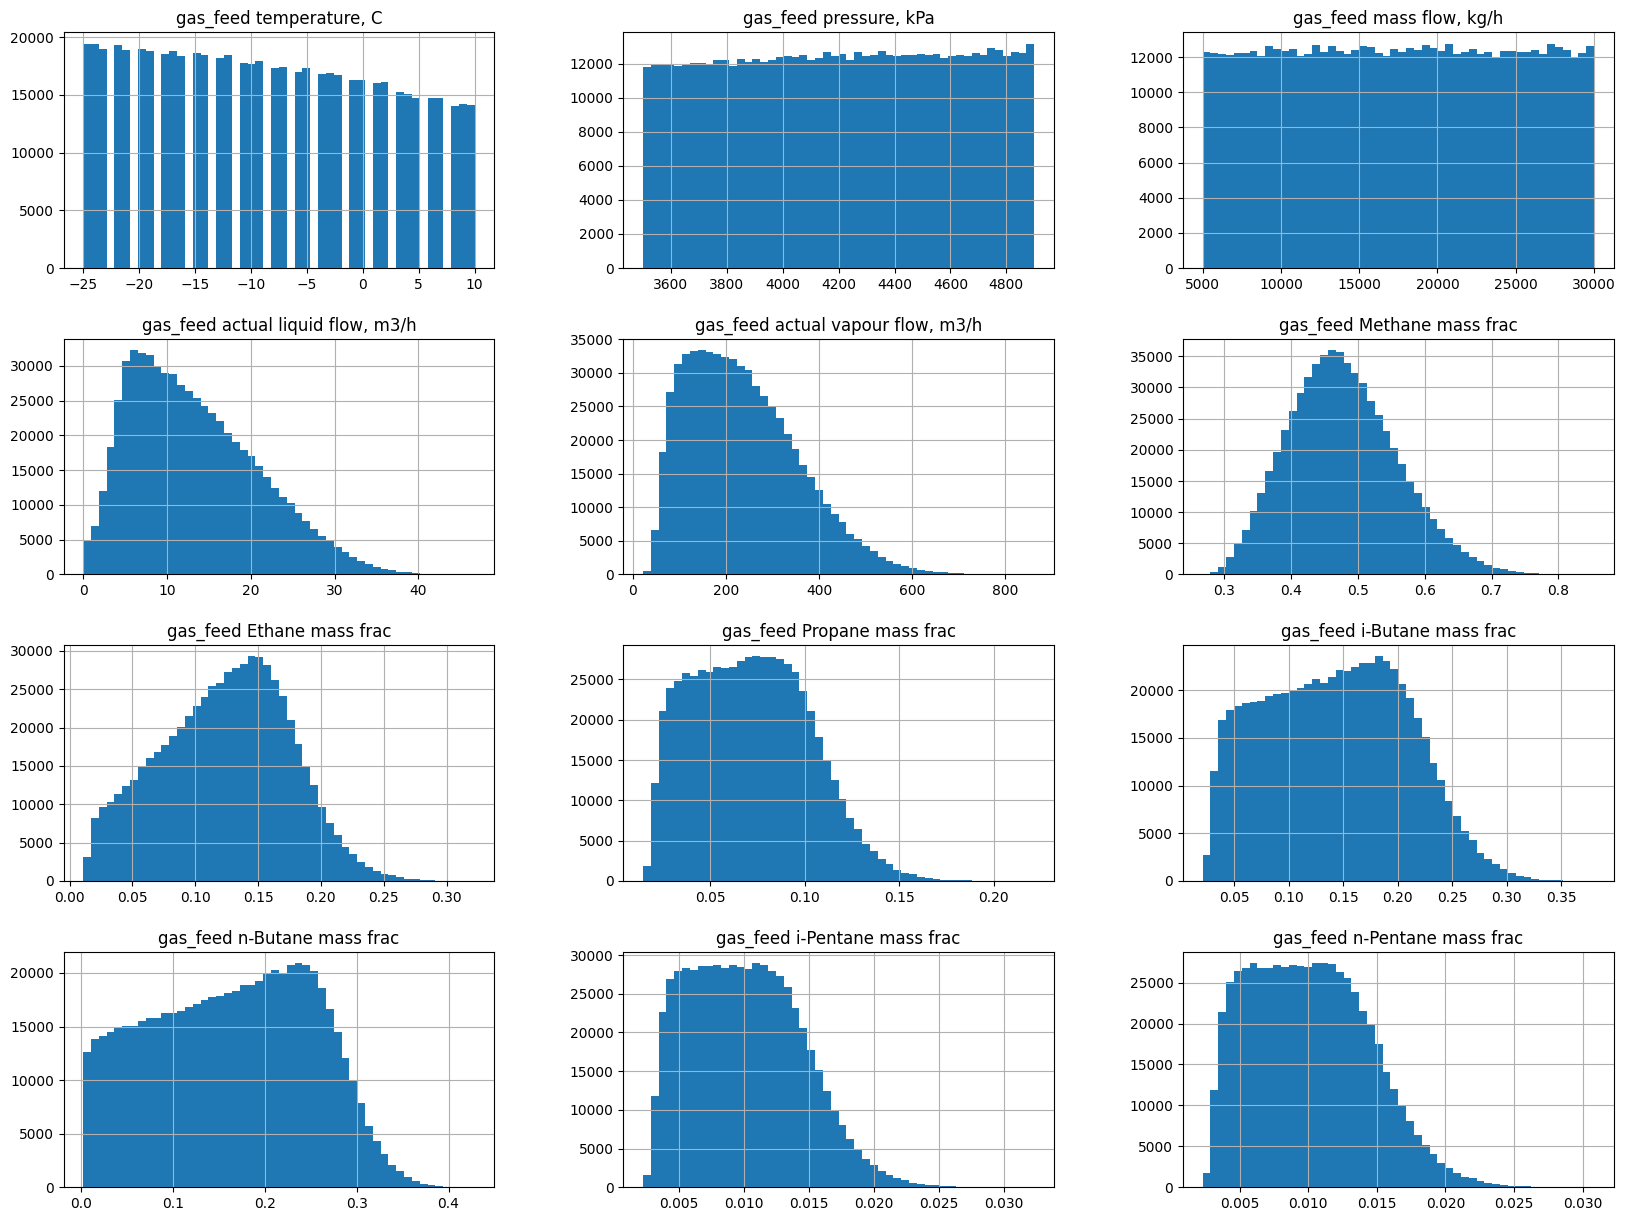

In [23]:
feed_prod_vol_flow.hist(bins=50, figsize=(20, 15));

In [24]:
corr_matrix = feed_prod_vol_flow.corr()

corr_matrix['gas_feed actual liquid flow, m3/h'].sort_values(ascending=False)

gas_feed actual liquid flow, m3/h    1.000000
gas_feed mass flow, kg/h             0.723261
gas_feed n-Butane mass frac          0.397954
gas_feed actual vapour flow, m3/h    0.225261
gas_feed i-Butane mass frac          0.214191
gas_feed pressure, kPa               0.093939
gas_feed Propane mass frac          -0.009964
gas_feed Ethane mass frac           -0.058984
gas_feed i-Pentane mass frac        -0.087376
gas_feed n-Pentane mass frac        -0.090083
gas_feed temperature, C             -0.238838
gas_feed Methane mass frac          -0.548213
Name: gas_feed actual liquid flow, m3/h, dtype: float64

In [28]:
## Тестовая и обучающая выборки
X = feed_prod_vol_flow[[
    'gas_feed temperature, C', 'gas_feed pressure, kPa', 'gas_feed mass flow, kg/h', 'gas_feed Methane mass frac',
    'gas_feed Ethane mass frac',
    'gas_feed Propane mass frac', 'gas_feed i-Butane mass frac', 'gas_feed n-Butane mass frac',
    'gas_feed i-Pentane mass frac','gas_feed n-Pentane mass frac',
]]

y = feed_prod_vol_flow[[
    'gas_feed actual liquid flow, m3/h',
    'gas_feed actual vapour flow, m3/h'
]]

# Собираем трансформер столбцов
ct = make_column_transformer(
    (MinMaxScaler(), [
    'gas_feed temperature, C', 'gas_feed pressure, kPa', 'gas_feed mass flow, kg/h', 'gas_feed Methane mass frac',
    'gas_feed Ethane mass frac',
    'gas_feed Propane mass frac', 'gas_feed i-Butane mass frac', 'gas_feed n-Butane mass frac',
    'gas_feed i-Pentane mass frac','gas_feed n-Pentane mass frac',
                     ])
)

# Создаем обучающую и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Загружаем тренировочную выборку
ct.fit(X_train)

# Нормализуем данные
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

X_train_normal.shape, y_train.shape

((494360, 10), (494360, 2))

In [45]:
# Set random set
tf.random.set_seed(42)

# 1. Create a model
feed_prod_vol_flow_model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(2)
])

# 2. Compile the model
feed_prod_vol_flow_model.compile(
    loss='mae',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['mae']
)

# 3. Fit the model
feed_prod_vol_flow_model.fit(X_train_normal, y_train, epochs=40)

Epoch 1/40
15449/15449 [==============================] - 32s 2ms/step - loss: 2.0579 - mae: 2.0579
Epoch 2/40
15449/15449 [==============================] - 44s 3ms/step - loss: 0.9939 - mae: 0.9939
Epoch 3/40
15449/15449 [==============================] - 36s 2ms/step - loss: 0.8910 - mae: 0.8910
Epoch 4/40
15449/15449 [==============================] - 36s 2ms/step - loss: 0.8180 - mae: 0.8180
Epoch 5/40
15449/15449 [==============================] - 36s 2ms/step - loss: 0.7500 - mae: 0.7500
Epoch 6/40
15449/15449 [==============================] - 38s 2ms/step - loss: 0.7083 - mae: 0.7083
Epoch 7/40
15449/15449 [==============================] - 37s 2ms/step - loss: 0.6749 - mae: 0.6749
Epoch 8/40
15449/15449 [==============================] - 43s 3ms/step - loss: 0.6404 - mae: 0.6404
Epoch 9/40
15449/15449 [==============================] - 44s 3ms/step - loss: 0.6118 - mae: 0.6118
Epoch 10/40
15449/15449 [==============================] - 49s 3ms/step - loss: 0.5849 - mae: 0.5849

In [46]:
y_pred = feed_prod_vol_flow_model.predict(X_test_normal)

3863/3863 [==============================] - 4s 965us/step


In [57]:
x = 156
pred = y_pred[x]
pred

array([  7.092949, 350.02875 ], dtype=float32)

In [58]:
test = y_test.iloc[x]
test

gas_feed actual liquid flow, m3/h      6.926595
gas_feed actual vapour flow, m3/h    348.885917
Name: 30381, dtype: float64

## Определение массовых расходов продуктов сепаратора

In [59]:
list(data.columns)

['gas_feed temperature, C',
 'gas_feed pressure, kPa',
 'gas_feed mass flow, kg/h',
 'gas_feed molecular weight',
 'gas_feed Mass density, kg/m3',
 'gas_feed actual liquid flow, m3/h',
 'gas_feed actual vapour flow, m3/h',
 'gas_feed mass heat capacity',
 'gas_feed Methane mass frac',
 'gas_feed Ethane mass frac',
 'gas_feed Propane mass frac',
 'gas_feed i-Butane mass frac',
 'gas_feed n-Butane mass frac',
 'gas_feed i-Pentane mass frac',
 'gas_feed n-Pentane mass frac',
 'Q-104',
 'Q-100',
 'Comp Fraction',
 '1 temperature, C',
 '1 pressure, kPa',
 '1 mass flow, kg/h',
 '1 molecular weight',
 '1 Mass density, kg/m3',
 '1 actual liquid flow, m3/h',
 '1 actual vapour flow, m3/h',
 '1 mass heat capacity',
 '1 Methane mass frac',
 '1 Ethane mass frac',
 '1 Propane mass frac',
 '1 i-Butane mass frac',
 '1 n-Butane mass frac',
 '1 i-Pentane mass frac',
 '1 n-Pentane mass frac',
 '2 temperature, C',
 '2 pressure, kPa',
 '2 mass flow, kg/h',
 '2 molecular weight',
 '2 Mass density, kg/m3',
 

In [64]:
sep_prod_mass_flow = data[[
    'gas_feed temperature, C', 'gas_feed pressure, kPa', 'gas_feed mass flow, kg/h', 'gas_feed actual liquid flow, m3/h',
    'gas_feed actual vapour flow, m3/h', 'gas_feed Methane mass frac', 'gas_feed Ethane mass frac',
    'gas_feed Propane mass frac', 'gas_feed i-Butane mass frac', 'gas_feed n-Butane mass frac',
    'gas_feed i-Pentane mass frac', 'gas_feed n-Pentane mass frac',
    '1 mass flow, kg/h', '2 mass flow, kg/h'
]]

In [65]:
sep_prod_mass_flow.describe()

,"gas_feed temperature, C","gas_feed pressure, kPa","gas_feed mass flow, kg/h","gas_feed actual liquid flow, m3/h","gas_feed actual vapour flow, m3/h",gas_feed Methane mass frac,gas_feed Ethane mass frac,gas_feed Propane mass frac,gas_feed i-Butane mass frac,gas_feed n-Butane mass frac,gas_feed i-Pentane mass frac,gas_feed n-Pentane mass frac,"1 mass flow, kg/h","2 mass flow, kg/h"
count,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000
mean,-8.480579,4207.666418,17513.410166,13.334570,236.913322,0.477853,0.123608,0.071424,0.143099,0.163792,0.010122,0.010102,10708.440240,6804.969926
std,10.266356,403.397921,7206.613928,7.586198,119.499390,0.080848,0.050958,0.030397,0.064333,0.086969,0.004279,0.004274,5156.225297,3873.795315
min,-25.000000,3500.000000,5000.000000,0.000000,21.448718,0.267349,0.010872,0.014322,0.021081,0.002458,0.002234,0.002290,1178.371232,0.000000
25%,-17.000000,3860.000000,11290.000000,7.247971,141.562427,0.419732,0.086266,0.046392,0.089873,0.091571,0.006606,0.006578,6520.828264,3691.914667
50%,-9.000000,4211.000000,17518.000000,12.151037,220.801211,0.472422,0.126887,0.070418,0.143815,0.168010,0.009864,0.009854,10148.332833,6192.395464
75%,0.000000,4557.000000,23750.000000,18.383058,313.726759,0.530387,0.160727,0.093634,0.192630,0.235017,0.013161,0.013138,14193.118168,9389.228804
max,10.000000,4900.000000,30000.000000,46.708568,862.437275,0.853544,0.322328,0.221481,0.379844,0.428366,0.032362,0.030832,29970.000000,23148.669181


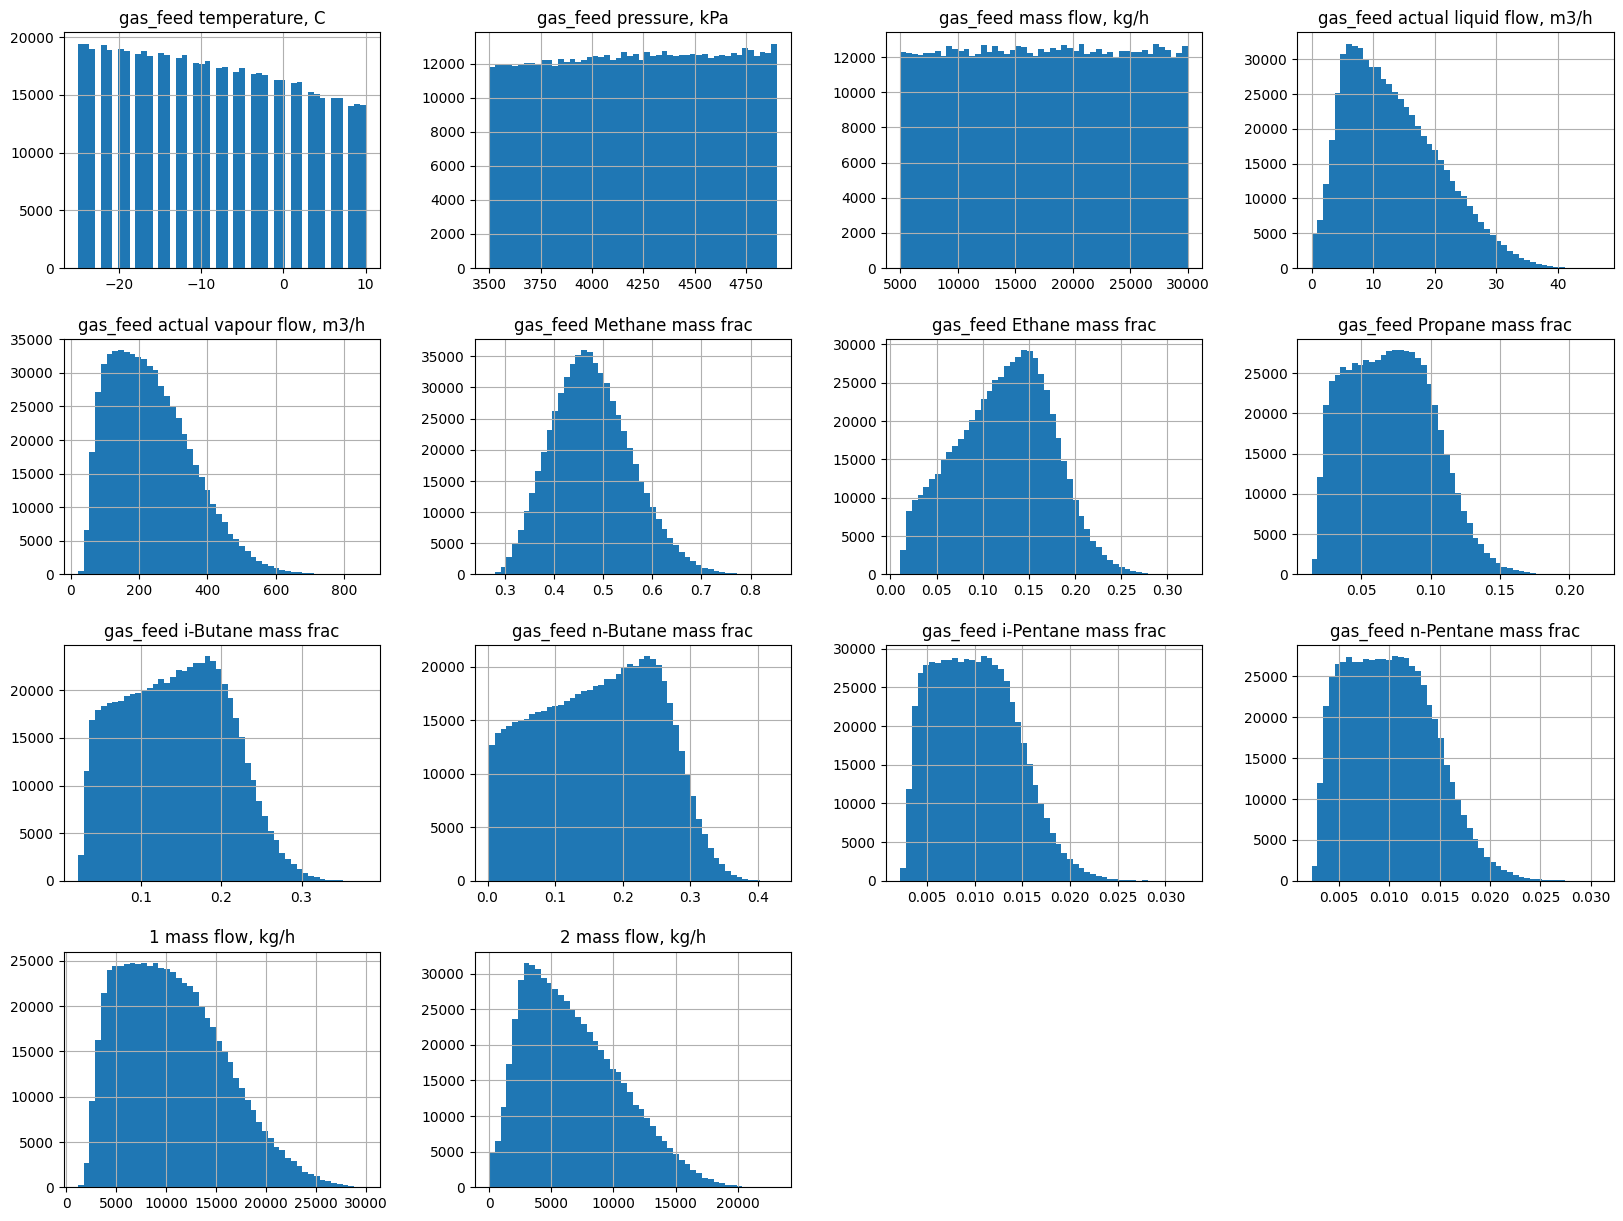

In [66]:
sep_prod_mass_flow.hist(bins=50, figsize=(20, 15));

In [67]:
corr_matrix = sep_prod_mass_flow.corr()

corr_matrix['1 mass flow, kg/h'].sort_values(ascending=False)

1 mass flow, kg/h                    1.000000
gas_feed actual vapour flow, m3/h    0.964563
gas_feed mass flow, kg/h             0.854649
gas_feed Methane mass frac           0.404069
gas_feed actual liquid flow, m3/h    0.260942
2 mass flow, kg/h                    0.258893
gas_feed temperature, C              0.187186
gas_feed Ethane mass frac            0.072754
gas_feed i-Pentane mass frac         0.064500
gas_feed n-Pentane mass frac         0.061846
gas_feed Propane mass frac           0.015669
gas_feed pressure, kPa              -0.045402
gas_feed i-Butane mass frac         -0.155920
gas_feed n-Butane mass frac         -0.314609
Name: 1 mass flow, kg/h, dtype: float64

In [68]:
## Тестовая и обучающая выборки
X = sep_prod_mass_flow[[
    'gas_feed temperature, C', 'gas_feed pressure, kPa', 'gas_feed mass flow, kg/h', 'gas_feed actual liquid flow, m3/h',
    'gas_feed actual vapour flow, m3/h', 'gas_feed Methane mass frac', 'gas_feed Ethane mass frac',
    'gas_feed Propane mass frac', 'gas_feed i-Butane mass frac', 'gas_feed n-Butane mass frac',
    'gas_feed i-Pentane mass frac', 'gas_feed n-Pentane mass frac',
]]

y = sep_prod_mass_flow[['1 mass flow, kg/h', '2 mass flow, kg/h',]]

# Собираем трансформер столбцов
ct = make_column_transformer(
    (MinMaxScaler(), [
    'gas_feed temperature, C', 'gas_feed pressure, kPa', 'gas_feed mass flow, kg/h', 'gas_feed actual liquid flow, m3/h',
    'gas_feed actual vapour flow, m3/h', 'gas_feed Methane mass frac', 'gas_feed Ethane mass frac',
    'gas_feed Propane mass frac', 'gas_feed i-Butane mass frac', 'gas_feed n-Butane mass frac',
    'gas_feed i-Pentane mass frac', 'gas_feed n-Pentane mass frac',
                     ])
)

# Создаем обучающую и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Загружаем тренировочную выборку
ct.fit(X_train)

# Нормализуем данные
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

X_train_normal.shape, y_train.shape

((494360, 12), (494360, 2))

In [69]:
# Set random set
tf.random.set_seed(42)

# 1. Create a model
sep_prod_mass_flow_model = tf.keras.Sequential([
    tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(2)
])

# 2. Compile the model
sep_prod_mass_flow_model.compile(
    loss='mae',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['mae']
)

# 3. Fit the model
sep_prod_mass_flow_model.fit(X_train_normal, y_train, epochs=50)

Epoch 1/50
15449/15449 [==============================] - 34s 2ms/step - loss: 748.3882 - mae: 748.3882
Epoch 2/50
15449/15449 [==============================] - 38s 2ms/step - loss: 50.0656 - mae: 50.0656
Epoch 3/50
15449/15449 [==============================] - 38s 2ms/step - loss: 46.1058 - mae: 46.1058
Epoch 4/50
15449/15449 [==============================] - 40s 3ms/step - loss: 44.4028 - mae: 44.4028
Epoch 5/50
15449/15449 [==============================] - 40s 3ms/step - loss: 41.8470 - mae: 41.8470
Epoch 6/50
15449/15449 [==============================] - 37s 2ms/step - loss: 41.3825 - mae: 41.3825
Epoch 7/50
15449/15449 [==============================] - 38s 2ms/step - loss: 39.4931 - mae: 39.4931
Epoch 8/50
15449/15449 [==============================] - 38s 2ms/step - loss: 39.1051 - mae: 39.1051
Epoch 9/50
10509/15449 [===================>..........] - ETA: 12s - loss: 37.2474 - mae: 37.2474

KeyboardInterrupt: 

In [11]:
y_pred = sep_prod_mass_flow_model.predict(X_test_normal)

3863/3863 [==============================] - 3s 824us/step


In [16]:
x = 245
pred = y_pred[x]
pred

array([15416.336,  9902.55 ], dtype=float32)

In [17]:
test = y_test.iloc[x]
test

1 mass flow, kg/h    15396.978981
2 mass flow, kg/h     9902.021019
Name: 490462, dtype: float64

In [18]:
sum(pred)

25318.8857421875

In [19]:
test['1 mass flow, kg/h'] + test['2 mass flow, kg/h']

25298.99999999999